## Word Association Analysis

In this notebook we will analyse a set of words scraped from ten online word association games. The word association game (WAG) is a popular forum game that can be found on message boards around the world. The aims of this analysis are getting more experience with data science (including but not limited to using jupyter notebooks, github, scraping, text mining, EDA and statistics) and obtaining more insight into the physological/neurological aspects of word associations. 

First, let's load the raw data set. It was scraped more than a year before writing this and I did not have any prior experience with webscraping, thus re-scraping the data might be a good idea. It will also result in more data because most WAGs are still active. However, for now I will continue to work with this dataset.  

In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('../data/processed/wordgame_20180814.csv') # 
df.head(8)

,author,word1,word2,source,sourceID
0,6204,"Hmm... ""Let them eat cake""\n, \n, Link! , , \...",^^^^^ fail (too much extra chit chat didnt kno...,WP,9
1,1765,Haircut.,Scalp,GOG,4
2,3569,inflamed,Fire,SAS,6
3,1329,symptoms,goody,GOG,4
4,4800,that hold me inside,I want to reach out.............,U2,8
5,1442,yeah,generic,GOG,4
6,5112,bullies,PKs,WP,9
7,6204,momentum,motion sickness,WP,9


Each row contains two words, of which word2 is the assocation given by the (anonymized) author as a response to word1. The associations are scraped from 10 different sources, both given by the abbreviation of the forum name and an integer code (don't ask me why). 

In [100]:
df.shape

(342267, 5)

We have as much as 0.3M word associations. Now, let's look at where I found all this data. 

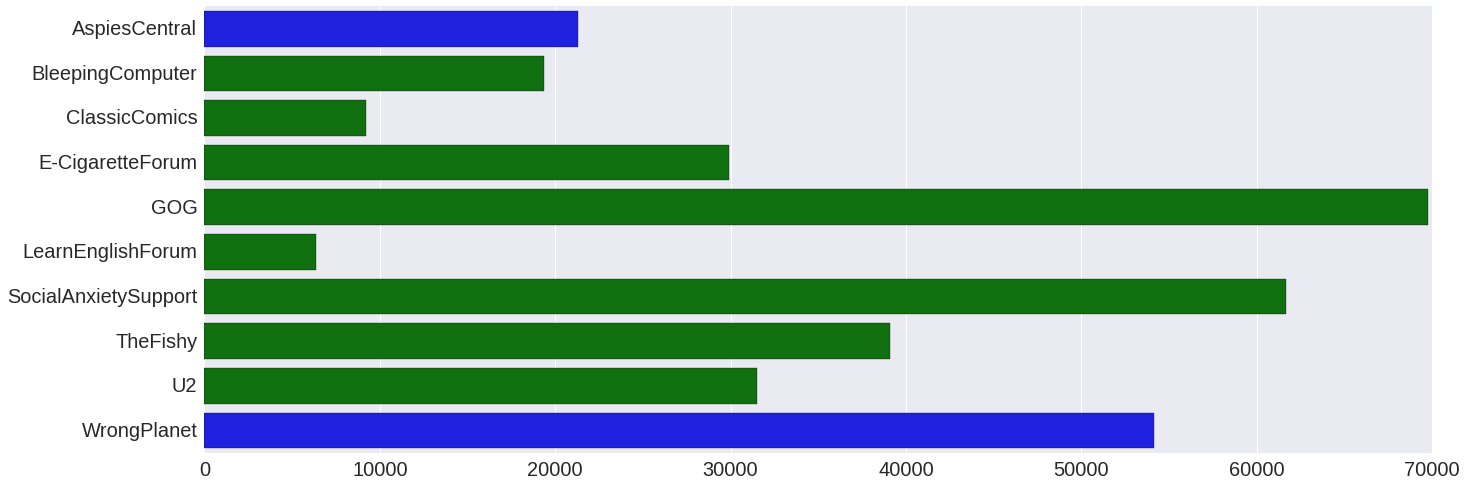

In [101]:
import matplotlib.pyplot as plt # plotting
import seaborn as sns # data visualization

sources_names = ["AspiesCentral", "BleepingComputer", "ClassicComics","E-CigaretteForum","GOG","LearnEnglishForum","SocialAnxietySupport","TheFishy","U2","WrongPlanet"] 
clrs = ['blue','green','green','green','green','green','green','green','green','blue']

# use a bigger fontsize   
sns.set(font_scale=2.0)

plt.figure(figsize=(22, 8))
freq = df.source.value_counts().sort_index()
sns.barplot(freq.tolist(), sources_names, orient="h", palette=clrs)
#plt.title(sources_list[i])
plt.xlabel('')
plt.ylabel('')
plt.show()

I started with scraping AspiesCentral and WrongPlanet, which are both communities for people with autism. Other sources were simply found by an online search for large communities with big WAG topics. Although all data is in English, the sources are extremely diverse; ranging from British football supporters (TheFishy) to non-native English speakers (LearnEnglishForum). And sometimes the participants were strictly following the games' rules, but more often the data is really messy. So if you want to practice your data cleaning skills, you have found the perfect data set ;) Also, keep reading if you're more interested in things like classifation (autistic people vs. neuro-typicals?) ...

But before we go on to that, there is still something very important we have to look at first. If you know something about statistics you probably know the importance of a balanced experiment setup. Preferably, we have an equal amount of data from each source (but we already know that we do not have that) and each author should have roughly an equal amount of posts. Let's see whether thats assumption is valid. 

In [102]:
print("Number of authors: " + str(len(df.author.unique())))
print("Optimal number of posts/author: " + str(len(df)/len(df.author.unique())))
authors = df.author.value_counts() # list of authors sorted by their number of posts
print("Median number of posts/author: " + str(authors.median()))
print("Maximum number of posts/author: " + str(authors.max()) + " (" + str(round((authors.max()/authors.sum()*100),1)) + "%)") 

Number of authors: 6386
Optimal number of posts/author: 53.596461008456
Median number of posts/author: 3.0
Maximum number of posts/author: 12209 (3.6%)


NO. The data is extremely skewed. Some authors are almost addicted to their word association game. One person alone accounts for 3.6% of all data (12209 posts!), whereas approximately 54 posts per author would be optimal. Can we fix this? 

In [ ]:
authors = df.author.value_counts() # list of authors sorted by their number of posts
authors = authors[99:] # remove 100 most active authors 
print("Maximum number of posts/author: " + str(authors.max()) + " (" + str(round((authors.max()/authors.sum()*100),2)) + "%)") 
print("Number of posts left: " + str(authors.sum()))
sns.distplot(authors)
plt.xlabel('posts per author')

Even when we would remove the 100 most WAG addicted authors and accept that we loose 50% of all data (in other words: 50% of all data comes from only 100 people!), the distribution of authors is still very skewed. Therefore, I decided to keep all data from all authors in the dataset, but keep in mind that this problem can have a huge influence on the results of this analysis. 

It's really time to start cleaning now... 

## Data cleaning
The script below shows how I removed unwanted interpunction (e.g. "...", "xD") and similar noise. The aim was to end up with mostly dictionary words, but without loosing to much valuable information. Choices were made by trail-and-error whilst keeping track of the amount of data lost. 

In [ ]:
import re # for regular expressions

df['word1'] = df['word1'].astype(str) # converts floats to strings
df['word2'] = df['word2'].astype(str)

def toAscii(s):
	return bytes(s, 'utf-8').decode('ascii','ignore')

def preprocess(x):
	#replace..
	x = x.replace('\n',' ') # (wrongplanet)
	x = x.replace('_','')
	x = x.replace("`", "'")
	x = x.replace("~", "")
	x = x.replace("^", "")
	x = x.replace("$$", "$") #allows $-signs but not multiple
	x = re.sub("xd", "", x, flags=re.I) # removes xD/XD/xd etc.. 

	#remove everything following...
	x = x.split("Quote:")[0] # removes posts containing quotes from SAS
	x = x.split("Sent from my")[0] # removes mobile Tapatalk message (SAS)
	x = x.split("Edited by")[0] # bleeping_computer: additional post info was scraped
	x = x.split("Posted via")[0] #sas
	if(x.find("said:") > 1): x = '' #classic comics: removes posts containing quotes
	x = x.split("/")[0]
	x = x.split("(")[0]
	x = x.split(",")[0]
	x = x.split("*")[0]
	x = x.split("\u00a0")[0]
	x = x.split("--")[0]
	x = x.split("*")[0]
	x = x.split('"')[0]
	x = x.split(".")[0]
	x = x.split("!")[0]
	x = x.split("?")[0]
	x = x.split("=")[0]
	x = x.split("[")[0]
	x = x.split("{")[0]
	x = x.split(":")[0]
	x = x.split(";")[0]
	x = x.split(">")[0]
	x = x.split("<")[0] # deals with <comments> and <333 

	#remove leading characters
	x = x.lstrip("+")
	x = x.lstrip("-")
	x = x.lstrip("&")
	x = x.lstrip("'")
	x = x.lstrip(' ')

	#remove trailing characters		
	x = x.rstrip('-M') # crazy 'signature' by a person with many posts..
	x = x.rstrip("'")
	x = x.rstrip(' ')
	x = x.rstrip('\u00a0') # removes trailing non-breaking spaces (the fishy)
	
	return x

# delete all words containing non-ascii characters
df['word1'] = df['word1'].apply(lambda x: toAscii(x))
df['word2'] = df['word2'].apply(lambda x: toAscii(x))

# clean data
df['word1'] = df['word1'].apply(lambda x: preprocess(x))
df['word2'] = df['word2'].apply(lambda x: preprocess(x))

#convert all to lowercase
df['word1'] = df['word1'].apply(lambda x: x.lower())
df['word2'] = df['word2'].apply(lambda x: x.lower())

df = df.replace('',np.NaN)

# compute fraction NaN values
print(df['word2'].isnull().sum()/len(df))

# drop all pairs containing NaN values
df = df.dropna(axis=0, how='any').reset_index(drop=True)

In [ ]:
df.head(8)

That looks better, right? 

Additionally, some word pairs consist of two identical words. This is possibly the result of quoting the post of the previous author combined with incorrect scraping/data cleaning or it was done on purpose. Either way, I will not result in useful insights about word associations. We remove these pairs below. 

In [ ]:
df['equal'] = df.apply(lambda x: str(x.word1)==str(x.word2), axis=1)
print(str(df['equal'].sum()) + " pairs will be removed") # number of pairs where word1==word2
df = df[df['equal']==False] 
df = df.drop('equal', 1) # delete equal column

In [ ]:
## save cleaned/preprocessed data
df.to_csv("../data/processed/wordgame_20180816_pr.csv", sep=',', index=False)

## Words!
Now we completed the data cleaning it is finally time to look at some words! Which words are the most frequently on our mind? I had really no idea about this before I did this analysis. 

In [ ]:
# compute term frequency (TF) feature
df['tf'] = df.groupby(['word2'])['word2'].transform('count')

frequent_words = df.drop_duplicates(subset=['word2']).sort_values(by=['tf'], ascending=False).head(10)
frequent_words[['word2','tf']] # or simply use value_counts() ... 

I must agree that most of these things are also pretty important for me too. Especially food, water and my dog. ;)

Note that due to the nature of the game each word is both an association as a cue for the next participant. As a result the list of word1's is roughly\* similar to the list of word2's. This is why I only computed the frequencies of word2 (using word1 instead would have given the same results). 

\*data cleaning did remove some rows

The same analysis is possible for pairs instead of words. Which word pairs are the most frequent? 

In [ ]:
df['pair'] = df.apply(lambda x: str(x.word1) + ":" + str(x.word2), axis=1)
df.pair.value_counts().head(11)

Again I was really surprised that some associations are much more frequent than others (me->you is 85 times in the dataset!).

## Feature Extraction
Time to get serious now. We can't call this text mining without some sort of feature extraction, right? We already have the term frequency, but we can extract MUCH more information from this dataset. We're starting with the syntactic features. 

## Syntactic Features
### Word length

In [ ]:
df['len1'] = df['word1'].apply(lambda x:len(x))
df['len2'] = df['word2'].apply(lambda x:len(x))
df['ldiff'] = df['len1'] - df['len2'] # length difference between word1 and word2 

# plots the length features (because I like plots ...)
plt.figure(figsize=(11, 6))
f = sns.kdeplot(df['len1'])  
g = sns.kdeplot(df['len2'])  
h = sns.kdeplot(df['ldiff'])  
#plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-20,20])
plt.show()

Most strings have length 4 and often both words have an equal length.

### Prefices and Suffices
Looking at the word pairs again, do they have a common prefix or suffix? And what is the length of this prefix/suffix? This might seem useless, but I found many syntactic associations (eg. bowels->vowels) in the dataset. (In my opinion this is not how the game should be played, but strictly speaking syntactic associations are still associations...).

In [ ]:
import os
df['prefix'] = df.apply(lambda r: os.path.commonprefix([r.word1, r.word2]), axis=1)
df['pl']= (df['prefix'].apply(lambda x: len(x)))
df['suffix'] = df.apply(lambda r: os.path.commonprefix([r.word1[::-1], r.word2[::-1]]), axis=1)
df['suffix'] = df['suffix'].apply(lambda x:x[::-1]) #re-reverse suffix
df['sl']= (df['suffix'].apply(lambda x: len(x)))

print("Most frequent prefices: " + str(df.prefix.value_counts().head(12).index))
print("Most frequent suffices: " + str(df.suffix.value_counts().head(12).index))

Nothing unexpected here... 

### Levenstein Distance

Levenshtein distance (also called Edit Distance) is a measure of the similarity between two strings. It is minimum the number of deletions, insertions, or substitutions required to transform the first string into the second.

In [ ]:
import Levenshtein

def levenshtein(r): #calculates levenstein distance
	return Levenshtein.distance(r.word1, r.word2)

df['edit'] = df.apply(levenshtein, axis=1)

Just for fun, here are some random word pairs from the dataset with edit distance=1.

In [ ]:
df[['pair','edit']].drop_duplicates(subset=['pair']).sort_values(by=['edit'], ascending=True).head(10)

This concludes the syntactic feature extraction. In the next section we move on to the semantic features such as word similarity. :)

## Semantic Features
Although we did extract some information using the syntactic approach, in most cases basic features such as word length and edit distance will not explain why someone has a specific association by any given cue. We still lack knowledge about the meaning of these words. When looking at the data yourself it was probably very easy to understand the word pairs (I must admit that I googled some curious word pairs ...). However, for a computer this is a very challenging task. 

Luckily we do not have to start from scratch with this. Some smart people from Google have created Word2Vec embeddings that can be used to compute the similarity of two words. Furthermore, an NLTK wordnet can be used to identify nouns, synonyms, antonyms, hypernyms, hyponyms, and so on.  

### Word2Vec

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('../data/external/GoogleNews-vectors-negative300.bin', binary=True)
print('Loaded word embeddings')

In [ ]:
df['word1w2v'] = df.word1.apply(lambda x:(x.replace(" ", "_")))
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_model.vocab))
#print(df[df.inw2v1==False].head(100).word1w2v.tolist())
#1-df.inw2v1.sum()/len(df)
#df['inw2v'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)
#df = df.drop('inw2v1', 1)
#df = df.drop('inw2v2', 1)


In [ ]:
df.ix[~df.inw2v1, 'word1w2v'] = df.ix[~df.inw2v1].word1w2v.apply(lambda x:x.title())
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_model.vocab))

In [ ]:
df.ix[~df.inw2v1, 'word1w2v'] = df.ix[~df.inw2v1].word1w2v.apply(lambda x:x.upper())
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_model.vocab))

In [ ]:
df['word2w2v'] = df.word2.apply(lambda x:(x.replace(" ", "_"))) # the example -> the_example
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_model.vocab)) 
df.ix[~df.inw2v2, 'word2w2v'] = df.ix[~df.inw2v2].word2.apply(lambda x:x.title()) # the_example -> The_Example
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_model.vocab))
df.ix[~df.inw2v2, 'word2w2v'] = df.ix[~df.inw2v2].word2.apply(lambda x:x.upper()) # The_Example -> THE_EXAMPLE
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_model.vocab))

df['inw2v'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)
#df = df.drop('inw2v1', 1)
#df = df.drop('inw2v2', 1)

df.inw2v.sum()/len(df)

In [ ]:
dfwords = df[(((df.word1 != df.word1w2v) | (df.word2!=df.word2w2v)) & df.inw2v)]
dfwords[['word1','word2','word1w2v', 'word2w2v']].head(12)

More than 18% of all word pairs contain one or more strings that are not known in the Word2Vec vocabulary. For these pairs we can not compute the word similarity feature. The similarities for the other pairs are computed below. 

In [18]:
df['sim'] = np.nan # similarity for unknown word pairs
df.ix[df.inw2v, 'sim'] = df.ix[df.inw2v].apply(lambda r:w2v_model.similarity(r.word1, r.word2), axis=1)

I'll show you some word pairs with highly similar words (according to Google) below. 

In [19]:
df[['pair','sim']].drop_duplicates(subset=['pair']).sort_values(by=['sim'], ascending=False).head(11)

,pair,sim
207751,four:three,0.970343
39307,three:four,0.970343
2488,north:south,0.967454
22226,south:north,0.967454
107632,east:west,0.965323
38208,west:east,0.965323
47296,four:five,0.960630
101492,2:3,0.954324
153561,six:seven,0.952351
188996,five:six,0.950833


And a plot of the similarity distributions... 

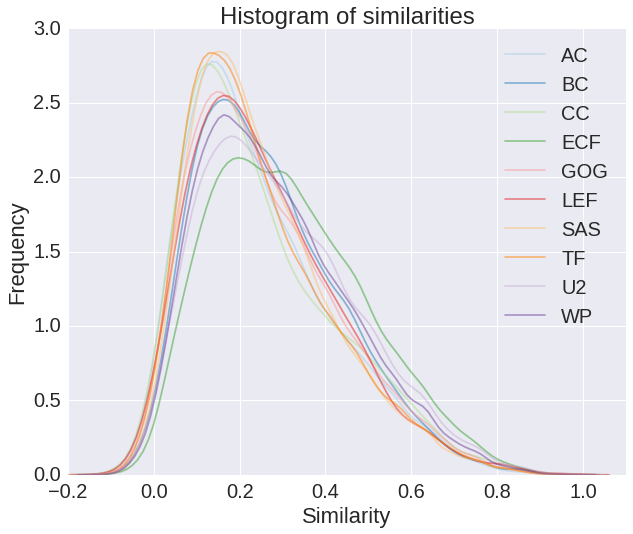

In [20]:
w2vdf = df[df.inw2v==True] # only keep pairs with similarity scoresb

pal = sns.color_palette("Paired", 10)
plt.figure(figsize=(22, 8))
plt.subplot(1,2,1)
for i in range(0,10,1):
    s = w2vdf[w2vdf['sourceID']==i]
    #print(s.sim.mean())
    sns.kdeplot(s['sim'], alpha=0.5, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-0.2,1.1])

plt.show()

The word pairs from the E-Cigarette Forum (ECF) seem to have the highest similarities on average. Negative similarities are rare, but also possible. (Read about cosine similarity if you're interested in the mathematics behind the Word2Vec similarities)

Additionally I also wanted to plot some of the word vectors. It is not possible to plot these directly, because each word is represented as a 300 dimensional vector (have you ever seen a 300-D plot?), but using other algorithms (eg. t-SNE) we can reduce the number of dimensions.

First, I plot all assocations for cues "life" and "death" in a 2D scatterplot. Frequent assocations (with frequency > 5) are annotated. Similarly, the associations for cues "food" and "chocolate" are plotted. Note: The t-SNE algorithm has a random component, so setting a different random seed value can result in completely different plots.

In [21]:
from sklearn.manifold import TSNE

sampleA = w2vdf[(w2vdf['word1'].isin(["death","life"]))][:] # select only pairs with word1=life||death
sampleA['wv2'] = sampleA['word2'].apply(lambda x: w2v_model.word_vec(x)) # compute word vector
sampleA['c'] = sampleA.groupby(['word2'])['word2'].transform('count') # count duplicate pairs
#del w2v_model

In [22]:
model = TSNE(random_state=552).fit_transform(sampleA['wv2'].tolist()) # Compute reduced word-vectors
sampleA['x'] = model[:,0]
sampleA['y'] = model[:,1]

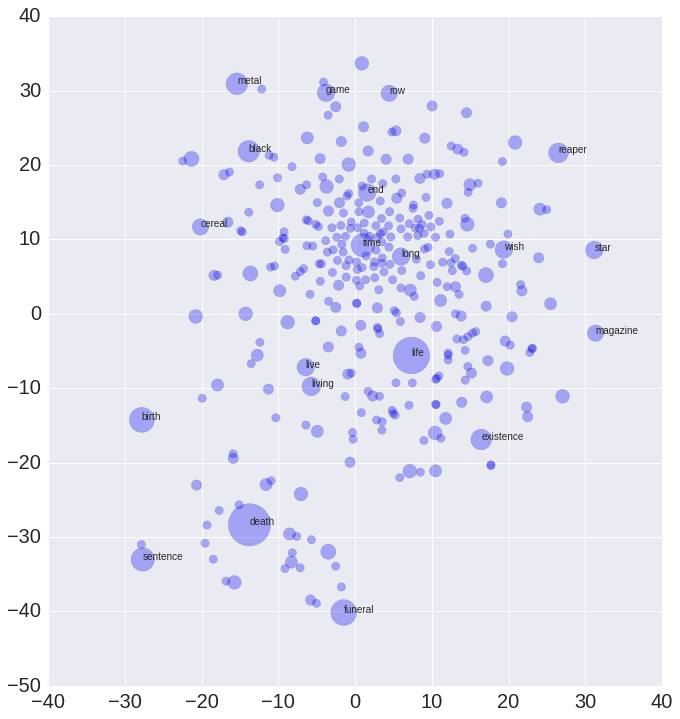

In [23]:
sampleA = sampleA.drop_duplicates(subset=['word2']) 
fig, ax = plt.subplots()
fig.set_figwidth(11)
fig.set_figheight(12)
ax.scatter(sampleA.x, sampleA.y, marker='o', s=30+40*sampleA.c, alpha=0.3)
for j in range(0,len(sampleA)):
    if(sampleA.c.iloc[j] > 5):
        ax.annotate(sampleA.word2.iloc[j], (sampleA.x.iloc[j], sampleA.y.iloc[j]))
plt.show()

In [24]:
sampleB = w2vdf[(w2vdf['word1'].isin(["food","chocolate"]))][:] # select only pairs with word1=food||chocolate
sampleB['wv2'] = sampleB['word2'].apply(lambda x: w2v_model.word_vec(x)) # compute word vector
sampleB['c'] = sampleB.groupby(['word2'])['word2'].transform('count') # count duplicate pairs

In [25]:
model = TSNE(random_state=23).fit_transform(sampleB['wv2'].tolist()) # Compute reduced word-vectors
sampleB['x'] = model[:,0]
sampleB['y'] = model[:,1]

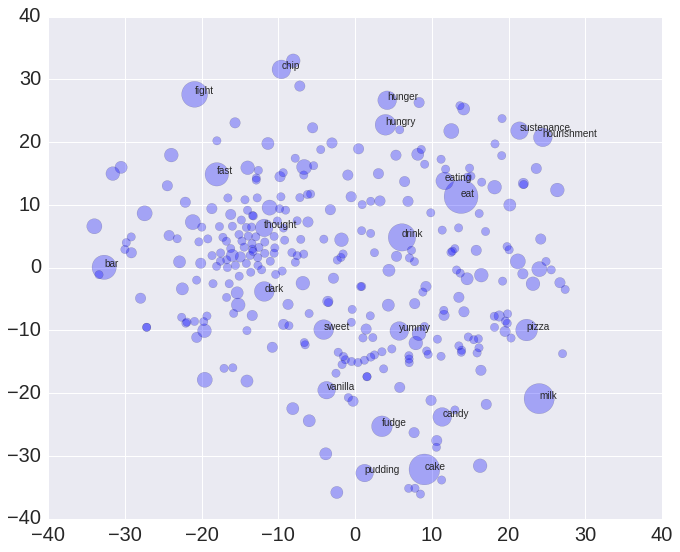

In [26]:
sampleB = sampleB.drop_duplicates(subset=['word2']) 
fig, ax = plt.subplots()
fig.set_figwidth(11)
fig.set_figheight(9)
ax.scatter(sampleB.x, sampleB.y, marker='o', s=30+40*sampleB.c, alpha=0.3)
for j in range(0,len(sampleB)):
    if(sampleB.c.iloc[j] > 5):
        ax.annotate(sampleB.word2.iloc[j], (sampleB.x.iloc[j], sampleB.y.iloc[j]))
plt.show()

I hope this gives you an idea about the representation of words in a x-dimensional (in this case 2-dimensional) space (or otherwise I hope you appreciated seeing these nice scatterplots). 

### WordNet / NLTK
Besides Word2Vec there exist many other sources that can provide semantic information about words. An important source is WordNet, which is a lexical database for the English language, which was created by Princeton, and is part of the NLTK corpus. It can be used to classify words as nouns, verbs and more. Word pairs can be identified as synonyms, antonyms, hypernyms and hyponyms. 

In the code below we create (boolean) features for nouns, synonyms, antonyms, hypernyms and hypernyms. (or at least that's what I attempted to do because I did not fully understand the ntlk.corpus package)

In [27]:
from itertools import chain
from nltk.corpus import wordnet

nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')} 
df['noun'] = df['word2'].apply(lambda x:(x in nouns)) 

In [28]:
def isSynonym(r):
    synonyms = wordnet.synsets(r.word1)
    lemmas = set(chain.from_iterable([w.lemma_names() for w in synonyms]))
    return (r.word2 in lemmas)

df['synonym'] = df.apply(isSynonym, axis=1)

In [29]:
def isAntonym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        for l in syn.lemmas():
            if l.antonyms():
                h.append(l.antonyms()[0].name().split('.')[0]) 
    return (r.word2 in h)

df['antonym'] = df.apply(isAntonym, axis=1)

Hyponymy shows the relationship between a generic term (hypernym) and a specific instance of it (hyponym).

In [30]:
def isHypernym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hypernyms():
            h.append(syn.hypernyms()[0].name().split('.')[0])
    return (r.word2 in h)
df['hypernym'] = df.apply(isHypernym, axis=1)

In [31]:
def isHyponym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hyponyms():
            h.append(syn.hyponyms()[0].name().split('.')[0]) 
    return (r.word2 in h)
df['hyponym'] = df.apply(isHyponym, axis=1)

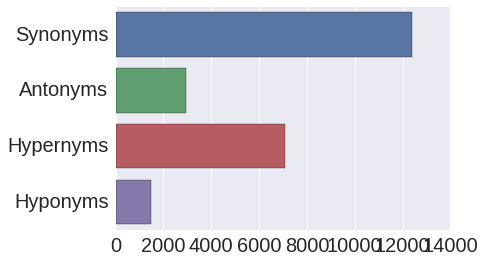

In [32]:
counts = [df.synonym.sum(), df.antonym.sum(), df.hypernym.sum(), df.hyponym.sum()]
semantic_types = ["Synonyms", "Antonyms", "Hypernyms", "Hyponyms"]
sns.barplot(counts, semantic_types, orient="h")
plt.show()

The dataset doesn't contain many word pairs that have semantic relationships (or the WordNet did not return the correct results), but as expected synonyms are the most represented in the WAG data. 

## Psychological features
Last but not least we are going to enrich the data with some psychological features. 

### Autism
We have absolutely no supplemental information, such as gender or age, about the authors in this dataset. However, we can assume that authors from AC and WP are more likely to have an autism spectrum disorder (ASD) and that authors from other sources are more likely not to have ASD (given that the current ASD prevalence estimate is < 2%). Still, it's a HUGE assumption to classify authors based on their presence in a specific online community, but I'm going to include this 'feature' anyways.

In [34]:
df['ASD'] = df['sourceID'].apply(lambda x:int((x%9)==0)) # 0= AspiesCentral, 9=WrongPlanet
print("Percentage of data from persons with ASD (based on assumption!): " + str(round(df.ASD.mean()*100,1)))

Percentage of data from persons with ASD (based on assumption!): 22.2


### Age-of-Acquisition
Age of Acquisition is a psycholinguistic variable referring to the age at which a word is typically learned.

In [35]:
import csv

reader = csv.reader(open('../data/external/AoA_ratings_Kuperman.csv', 'r'))

AoA = {} 
for k, v in reader: # read data from CSV in to python dictionary
    if(v != 'NA'):
       AoA[k] = v

df['AoA'] = df['word2'].apply(lambda x:float(AoA[x]) if x in AoA else np.nan) 
len(df[df['AoA'].isnull()])/len(df)

0.2814713520581056

## Concreteness rating
Another phycholinguistic variable is the concreteness rating. 

## Correlation

In [ ]:
cordf = df[df.inw2v==True]
cordf = cordf[~cordf.AoA.isnull()]
cordf = cordf.drop('inw2v',1)
cordf = cordf.drop('author',1)
cordf = cordf.drop('len1',1)
cordf = cordf.drop('ldiff',1)
cordf = cordf.drop('sourceID',1)
print(len(cordf))

f, ax = plt.subplots(figsize=(10, 8))
corr = cordf.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()

In [ ]:
# save features
df.to_csv("../data/processed/wordgame_20180816_ft.csv", sep=',', index=False)